In [1]:
import numpy as np
from qepy.io import QEInput
from qepy.driver import Driver
#from ase.io.trajectory import Trajectory
from ase.io.trajectory import Trajectory
from ase.build import bulk
from ase import Atoms
import matplotlib.pyplot as plt

In [2]:
from ase.units import kJ
from ase.eos import EquationOfState

In [3]:
atoms = bulk('Li', 'bcc', 3.51)

In [4]:
qe_options = {
    '&control': {
        'calculation': "'scf'",
        'prefix': "'oepp'",
        'pseudo_dir': "'/projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/PP/'"},
    '&system': {
        'ibrav' : 0,
        'degauss': 0.02,
        # 'input_dft': "'pbe'",
        'ecutwfc': 80,
        'occupations': "'smearing'",
        'smearing': "'fermi-dirac'" 
    },
    '&electrons': {
        'conv_thr' : 1.0e-10,
        'mixing_beta': 0.3,},
     'atomic_species': ['Li 6.94 Li_OEPP_PZ.UPF'],
     'k_points automatic': ['4 4 4 0 0 0'],
}

In [5]:
alats = [0.8,0.85,0.9,0.95,0.975,1.0,1.025,1.05,1.075,1.1,1.15,1.2]
ks_ene = []
ks_rho = []
vol = []
atoms = bulk('Li', 'bcc', 3.51)
for x in alats:
    print(x)
    ta=atoms.copy()
    ta.cell *= x
    qe_options = QEInput.update_atoms(ta, qe_options = qe_options,  extrapolation=False)
    QEInput().write_qe_input('qe/'+str(x)+'.in', qe_options=qe_options)
    driver = Driver('qe/'+str(x)+'.in', logfile='qe/'+str(x)+'.out')
    driver.scf()
    ene = driver.get_energy()
    driver.stop()
    ks_ene.append(ene)
    vol.append(ta.get_volume())

ee=np.array(ks_ene)
vv=np.asarray(vol)
np.save('energy.npy', ee)
np.save('volume.npy', vv)

0.8
0.85
0.9
0.95
0.975
1.0
1.025
1.05
1.075
1.1
1.15
1.2


In [6]:
ee_eos= EquationOfState(vv/1, ee*27.211385/2, eos='murnaghan') 
vv0, ee0, B = ee_eos.fit()
eos = [ vv0, ee0, B / kJ * 1.0e24]

In [7]:
eos

[19.541795493252632, -9.211349591295626, 12.455438381449008]

<AxesSubplot: title={'center': 'murnaghan: E: -9.211 eV, V: 19.542 Å$^3$, B: 12.455 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

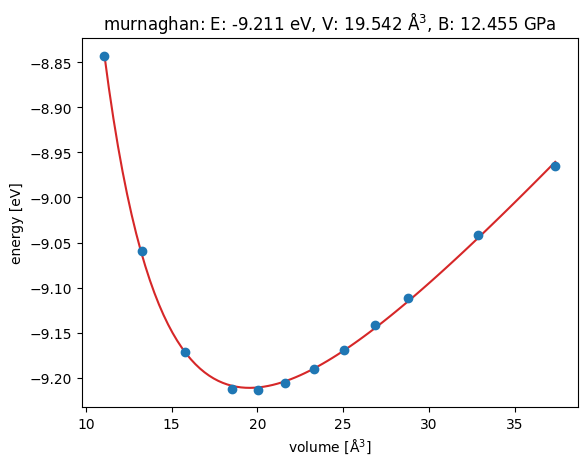

In [8]:
ee_eos.plot()

In [11]:
# Batteries/Li2S_interface/OF/Li/metal/PP/OEPP/LDA/tf02vw/lda_tf02vw.psp8

In [12]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import environ
from ase.build import bulk
import numpy as np
from scipy.optimize import minimize
from scipy.signal import quadratic
from dftpy.api.api4ase import DFTpyCalculator
from dftpy.config import DefaultOption, OptionFormat

In [ ]:
e_revhc = []
v_revhc = []
for alat in alats: 
    atoms = bulk('Li', 'bcc', 3.51)
    conf = DefaultOption()
    conf['PATH']['pppath'] = './'
    conf['PP']['Li'] = 'PGBRV_LDA_revHC.psp8'
    conf['OPT']['method'] = 'CG'
    conf['KEDF']['kedf'] = 'revHC'
    conf['EXC']['xc'] = 'LDA'
    conf['JOB']['calctype'] = 'Energy Force'
    conf['OPT']['econv'] = 1.e-11
    conf['GRID']['ecut'] = 1600
    conf = OptionFormat(conf)
    calc = DFTpyCalculator(config=conf)
    atoms.set_calculator(calc)
    tta=atoms.copy()   
    tta.cell *= alat
    tta.set_calculator(calc)
    e_revhc.append(tta.get_potential_energy())
    v_revhc.append(tta.get_volume())

e_revhc=np.array(e_revhc)
v_revhc=np.asarray(v_revhc)
np.save('energy_revhc.npy', e_revhc)
np.save('volume_revhc.npy', v_revhc)

In [17]:
eos_revhc= EquationOfState(v_revhc/1, e_revhc, eos='murnaghan') 
v0_revhc, e0_revhc, B_revhc = eos_revhc.fit()
eos = [ vv0, ee0, B / kJ * 1.0e24]

<AxesSubplot: title={'center': 'murnaghan: E: -7.567 eV, V: 20.148 Å$^3$, B: 12.850 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

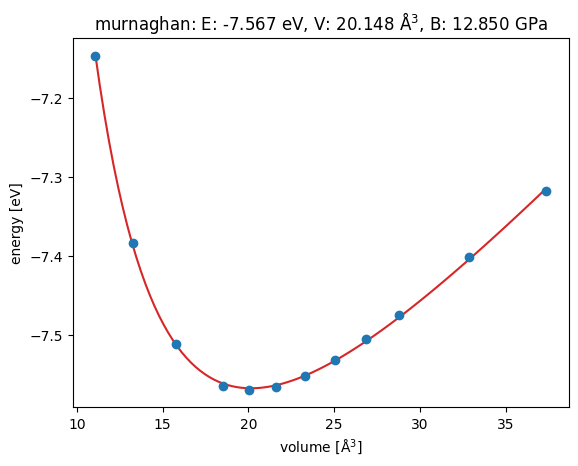

In [18]:
eos_revhc.plot()

In [ ]:
e_tf02vw = []
v_tf02vw = []
for alat in alats: 
    print(alat)
    atoms = bulk('Li', 'bcc', 3.51)
    conf = DefaultOption()
    conf['PATH']['pppath'] = './'
    conf['PP']['Li'] = 'PGBRV_LDA_revHC.psp8'
    conf['OPT']['method'] = 'CG'
    conf['KEDF']['kedf'] = 'TFvW'
    conf['KEDF']['y'] = 0.2
    conf['EXC']['xc'] = 'LDA'
    conf['JOB']['calctype'] = 'Energy Force'
    conf['OPT']['econv'] = 1.e-11
    conf['GRID']['ecut'] = 1600
    conf = OptionFormat(conf)
    calc = DFTpyCalculator(config=conf)
    atoms.set_calculator(calc)
    tta=atoms.copy()   
    tta.cell *= alat
    tta.set_calculator(calc)
    e_tf02vw.append(tta.get_potential_energy())
    v_tf02vw.append(tta.get_volume())

e_tf02vw=np.array(e_tf02vw)
v_tf02vw=np.asarray(v_tf02vw)
np.save('energy_tf02vw.npy', e_tf02vw)
np.save('volume_tf02vw.npy', v_tf02vw)

<AxesSubplot: title={'center': 'murnaghan: E: -7.592 eV, V: 20.618 Å$^3$, B: 10.440 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

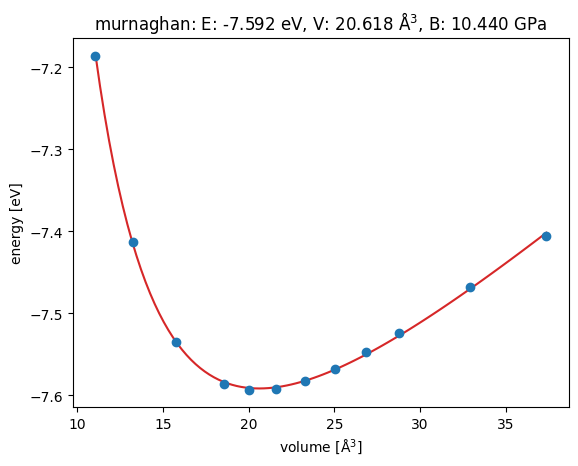

In [20]:
eos_tf02vw= EquationOfState(v_tf02vw/1, e_tf02vw, eos='murnaghan') 
v0_tf02vw, e0_tf02vw, B_tf02vw = eos_tf02vw.fit()
eos = [ vv0, ee0, B / kJ * 1.0e24]
eos_tf02vw.plot()

In [ ]:
e_lmgp = []
v_lmgp = []
for alat in alats: 
    print(alat)
    atoms = bulk('Li', 'bcc', 3.51)
    conf = DefaultOption()
    conf['PATH']['pppath'] = './'
    conf['PP']['Li'] = 'PGBRV_LDA_revHC.psp8'
    conf['OPT']['method'] = 'CG'
    conf['KEDF']['kedf'] = 'LMGP'
    # conf['KEDF']['y'] = 0.2
    conf['EXC']['xc'] = 'LDA'
    conf['JOB']['calctype'] = 'Energy Force'
    conf['OPT']['econv'] = 1.e-11
    conf['GRID']['ecut'] = 1600
    conf = OptionFormat(conf)
    calc = DFTpyCalculator(config=conf)
    atoms.set_calculator(calc)
    tta=atoms.copy()   
    tta.cell *= alat
    tta.set_calculator(calc)
    e_lmgp.append(tta.get_potential_energy())
    v_lmgp.append(tta.get_volume())

e_lmgp=np.array(e_lmgp)
v_lmgp=np.asarray(v_lmgp)
np.save('energy_lmgp.npy', e_lmgp)
np.save('volume_lmgp.npy', v_lmgp)

<AxesSubplot: title={'center': 'murnaghan: E: -7.567 eV, V: 20.158 Å$^3$, B: 12.786 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

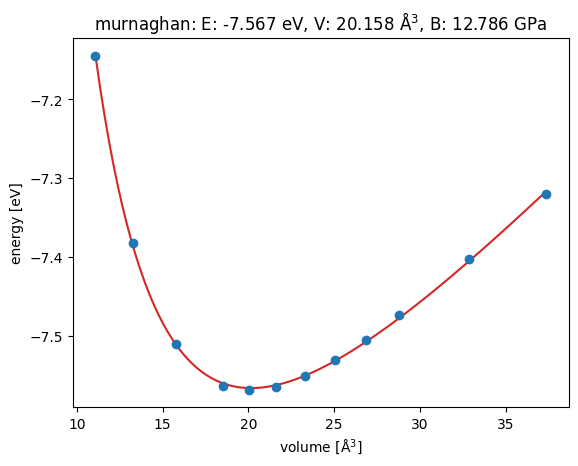

In [22]:
eos_lmgp= EquationOfState(v_lmgp/1, e_lmgp, eos='murnaghan') 
v0_lmgp, e0_lmgp, B_lmgp = eos_lmgp.fit()
eos = [ vv0, ee0, B / kJ * 1.0e24]
eos_lmgp.plot()

In [23]:
import pandas as pd

In [24]:
kedfs = ['KS', 'revHC', 'TF02vW', 'LMGP']
e0 = [ee0, e0_revhc, e0_tf02vw, e0_lmgp]
v0 = [vv0, v0_revhc, v0_tf02vw, v0_lmgp]
B0 = [B, B_revhc, B_tf02vw, B_lmgp]
eos = {}
for i,ke in enumerate(kedfs):
    eos[ke] = [v0[i], e0[i], B0[i]/ kJ * 1.0e24]

In [28]:
df = pd.DataFrame.from_dict(eos, orient='index', columns=[ 'Volume ($A^3$)', 'Energy (eV)', 'Bulk modulos (GPa)'])
df.reset_index(inplace=False)
df.rename(columns={'index': 'Element'}, inplace=True)
df.style\
    .format(precision=3, decimal=".")

,Volume ($A^3$),Energy (eV),Bulk modulos (GPa)
KS,19.542,-9.211,12.455
revHC,20.148,-7.567,12.850
TF02vW,20.618,-7.592,10.440
LMGP,20.158,-7.567,12.786


Text(0.5, 0, 'Volume ($A^{3}$)')

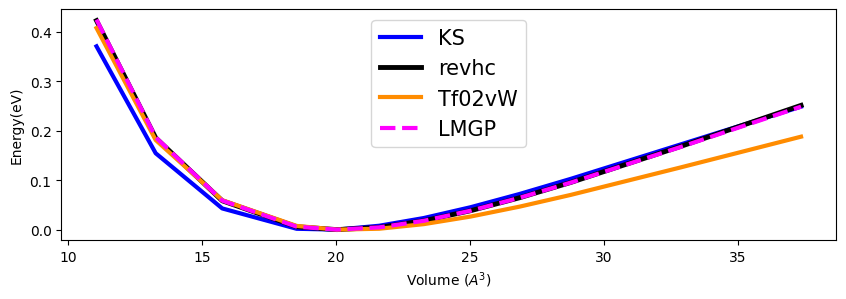

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))

plt.plot(vv, ee*27.211385/2-min(ee*27.211385/2), ls='-', lw=3,color='b',label='KS')
plt.plot(v_revhc, e_revhc-min(e_revhc), color='k', lw=3.5, label='revhc')
plt.plot(v_tf02vw, e_tf02vw-min(e_tf02vw), color='darkorange', lw=3.0, label='Tf02vW')
plt.plot(v_lmgp, e_lmgp-min(e_lmgp), ls='--', lw=3.0,color='magenta',label='LMGP')
plt.legend(fontsize=15)
plt.ylabel('Energy(eV)')
plt.xlabel('Volume ($A^{3}$)')
